# ***VAE for image generation***
Consider VAE model from
*Auto-Encoding Variational Bayes (2014, D.P. Kingma et. al.)*.  
We will implement a VAE model using Torch and apply it to the MNIST dataset.


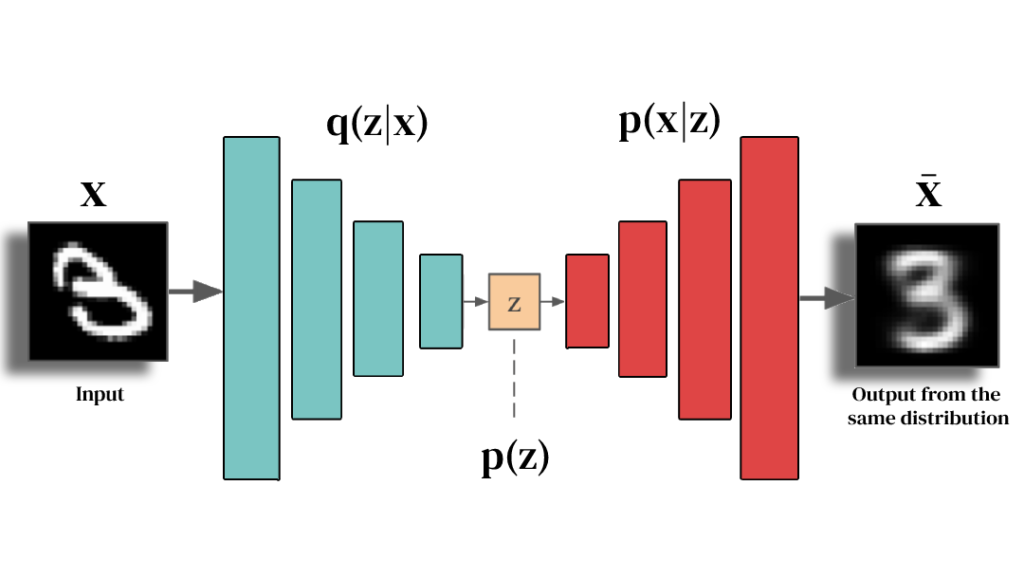


**Generative model:** We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.






**Implementation:**
Let's start with importing Torch and other necessary libraries:

In [1]:
import torch
import torch.nn as nn
import torch.distributions as dist

import numpy as np

from tqdm import tqdm

In [2]:
# Do not change the seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda:0


### ***Step1: Model Hyperparameters***



In [ ]:
dataset_path = '~/datasets'

batch_size = 20

# or use 128 for more speed :)
#batch_size = 128

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 200
latent_dim = 50

# Learning rate
lr = 1e-3

# Number of epoch
epochs = 20

### ***Step2: Load Dataset***



In [13]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_labels = test_dataset.targets

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

### ***Step3: Define the model***


In [14]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC = fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_std  = nn.Linear (hidden_dim, latent_dim)

        self.tanh = nn.Tanh()

        self.training = True

    def forward(self, x):
        h_1     = self.tanh(self.FC_enc1(x))
        h_2     = self.tanh(self.FC_enc2(h_1))
        mu    = self.FC_mean(h_2)  # mean / location
        log_var = self.FC_std(h_2)   # log variance

        return mu, log_var

In [15]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        #self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

    def forward(self, z):
        h_out_1  = self.tanh(self.FC_dec1(z))
        h_out_2  = self.tanh(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta


**Q3.1 (2 points)**  Below implement the reparameterization function.

In [24]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, std):
        eps = torch.randn_like(std)
        z = mean + std * eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        theta = self.Decoder(z)
        return theta, mean, log_var, z

### ***Step4: Model initialization***


In [17]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model_vae = Model(Encoder=encoder, Decoder=decoder)
model_iwae = Model(Encoder=encoder, Decoder=decoder)

model_vae.to(device)
model_iwae.to(device)

Model(
  (Encoder): Encoder(
    (FC_enc1): Linear(in_features=784, out_features=200, bias=True)
    (FC_enc2): Linear(in_features=200, out_features=200, bias=True)
    (FC_mean): Linear(in_features=200, out_features=50, bias=True)
    (FC_std): Linear(in_features=200, out_features=50, bias=True)
    (tanh): Tanh()
  )
  (Decoder): Decoder(
    (FC_dec1): Linear(in_features=50, out_features=200, bias=True)
    (FC_dec2): Linear(in_features=200, out_features=200, bias=True)
    (FC_output): Linear(in_features=200, out_features=784, bias=True)
    (tanh): Tanh()
  )
)

### ***Step5: Loss function and optimizer***


Our objective function is ELBO:
$E_{q(z)}\big[\log \frac{p(x,z)}{q(z)}\big]$

* **Q5.1 (1 point)** Show that ELBO can be rewritten as :

$E_{q(z)}\big[\log p(x|z)\big] - D_{KL} \big( q(z) \lvert \rvert  p(z)\big)$


*5.1 Your answer*

$\log p(x,z) = \log p(x \mid z) \cdot p(z)$

ELBO $= E_{q(z)}\big[\log \frac{p(x,z)}{q(z)}\big] = E_{q(z)}\big[\log p( x \mid z) + \log p(z) - \log q(z) \big ]$

We recognise the negative KL-divergence:

$E_{q(z)}\big[\log p(x \mid z) \big] - E_{q(z)}\big[\log \frac{q(z)}{p(z)}\big] = E_{q(z)}\big[\log p(x \mid z) \big] - D_{KL}\big (q(z) || p(z)\big)$





Consider the first term: $E_{q(z|x)}\big(\log p(x|z)\big)$

$E_{q(z|x)}\big(\log p(x|z)\big) = \int q(z|x) \log p(x|z) dz $

We can approximate this integral by Monte Carlo integration as following:

$\approx \frac{1}{L} \sum_{l=1}^L \log p(x|z_l) $, where $z_l \sim q(z|x)$.

Now we can compute this term using the analytic expression for $p(x|z)$. ( Remember we model each pixel as a sample drawn from a Bernoulli distribution).

Consider the second term: $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$

* **Q5.2 (2 points)** Kullback–Leibler divergence can be computed using the closed-form analytic expression when both the variational and the prior distributions are Gaussian. Write down this KL divergence in terms of the parameters of the prior and the variational distributions. Your solution should consider a generic case where the latent space is K-dimensional.

  *5.2 Your answer*

  $\frac{1}{L} \sum_{l=1}^L \log p(x|z_l) = \frac{1}{L} \sum_{l=1}^L \sum_{i=1}^D \big[ x_i \log (\theta_i) + (1 - x_i) \log(1 - \theta_i) \big ]$


  $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big) = - E_{q(z)}\big[\log q(z) - \log p(z)\big]$

  $ \log q(z) - \log p(z) = -\frac{k}{2}\log (2\pi) - \frac{1}{2} \sum_{k=1}^K\big[\log \sigma_k + \frac{(z_k - \mu_k)^2}{\sigma_k^2} - z_k^2 \big] + K\log 1 + \frac{K}{2}\log (2\pi) = - \frac{1}{2} \sum_{k=1}^K\big[\log \sigma_k + \frac{(z_k - \mu_k)^2}{\sigma_k^2} - z_k^2 \big ]$
  
  Taking the expectation with:
  
  $E_{q(z)} \big[ (z_k - \mu_k)^2 \big] = \sigma_k^2 \to E_{q(z)} \big[ \frac{(z_k - \mu_k)^2}{\sigma_k^2} \big] = 1$
  
  and

  $ E_{q(z)} \big [z_k^2 \big] = \mu_k^2 + \sigma_k^2 $

  We get:

  $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big) = \frac{1}{2} \sum_{k=1}^K \big( \mu_k^2 + \sigma_k^2 - 1 - \log \sigma_k^2 \big )$
  



**Q5.3 (2 points)** Now use your findings to implement the loss function, which is the negative of ELBO:

In [38]:
import torch.nn.functional as F

def calc_log_joint(x, theta, z):
    D = z.shape[1] # latent dim
    eps = 1e-8

    log_2pi = torch.log(torch.tensor(2 * torch.pi, device=z.device))
    log_p_x_z = torch.sum(x * torch.log(theta + eps) + (1 - x) * torch.log(1 - theta + eps), dim=1)
    log_p_z = -1/2 * D * log_2pi - 1/2 * torch.sum(z.pow(2), dim=1)
    return log_p_x_z + log_p_z

def calc_log_q_z(mean, log_var, z):
    # multivariate normal with diag variance
    D = z.shape[1] # latent dim
    eps = 1e-8

    log_2pi = torch.log(torch.tensor(2 * torch.pi, device=z.device))
    exponent = (z - mean)**2 / torch.exp(log_var + eps)


    return -1/2 * D * log_2pi - 1/2 * torch.sum(log_var + exponent, dim=1) 

def loss_function_VAE(x, theta, mean, z, log_var, k):
    # Compute ELBO for each sample
    elbos = []
    for i in range(k):
        log_joint = calc_log_joint(x[:, i, :], theta[:, i, :], z[:, i, :])
        log_q = calc_log_q_z(mean[:, i, :], log_var[:, i, :], z[:, i, :])
        elbo_sample = log_joint - log_q
        elbos.append(elbo_sample)
    
    # Stack: (batch_size, k)
    elbos = torch.stack(elbos, dim=1)
    
    # average of ELBOs
    return - elbos.mean(dim=1)

def loss_function_IWAE(x, theta, z, mean, log_var, k):
    # Compute log weights for each sample
    log_weights = []
    for i in range(k):
        log_joint = calc_log_joint(x[:, i, :], theta[:, i, :], z[:, i, :])
        log_q = calc_log_q_z(mean[:, i, :], log_var[:, i, :], z[:, i, :])
        log_w = log_joint - log_q
        log_weights.append(log_w)
    
    # Stack: (batch_size, k)
    log_weights = torch.stack(log_weights, dim=1)
    
    # IWAE bound: log(1/k * sum(exp(log_weights)))
    # Use log-sum-exp trick for numerical stability
    log_k = torch.log(torch.tensor(k, dtype=torch.float32, device=device))
    return - torch.logsumexp(log_weights, dim=1) - log_k


### ***Step6: Train the model***

**Q6.1 (1 points)** Two lines of codes are missing in the training loop below, one to propagate the input through the model and another to compute the loss. Fill in the missing lines.

In [37]:
from torch.optim import Adam

############################################ IWAE MODEL #########################################

def train_IWAE_model(model, k):
    print(f"Start training IWAE with {k} samples...")
    model.train()

    # optimizer
    optimizer = Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-4)

    pbar = tqdm(range(epochs))
    elbo_iwae = []
    for epoch in pbar:
        total_loss = 0
        total_samples = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            x = x.view(-1, x_dim)
            x = torch.round(x)

            optimizer.zero_grad()

            # Draw k samples for each data point
            batch_size = x.size(0)
            
            # Expand x to match: (batch_size * k, x_dim)
            x_expanded = x.unsqueeze(1).repeat(1, k, 1).view(batch_size * k, -1)
            
            # Forward pass with expanded batch
            theta, mean, log_var, z = model(x_expanded)
            
            # Reshape outputs: (batch_size, k, dim)
            theta = theta.view(batch_size, k, -1)
            z = z.view(batch_size, k, -1)
            mean = mean.view(batch_size, k, -1)
            log_var = log_var.view(batch_size, k, -1)
            x_reshaped = x_expanded.view(batch_size, k, -1)
            
            # IWAE loss
            loss = loss_function_IWAE(x_reshaped, theta, z, mean, log_var, k)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

        avg_loss = total_loss / total_samples

        pbar.set_description(f"Epoch {epoch+1}/{epochs},"
                            f" Loss: {avg_loss:.4f},"
                            f" IWAE Bound: {-avg_loss:.4f}")
        elbo_iwae.append(-avg_loss)

    print("Finish!!")
    return model, elbo_iwae

In [36]:
from torch.optim import Adam

############################################ VAE MODEL #########################################

def train_VAE_model(model, k=1):
    print(f"Start training VAE with {k} samples...")
    model.train()

    # optimizer
    optimizer = Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-4)
    
    pbar = tqdm(range(epochs))
    elbo = []
    for epoch in pbar:
        total_loss = 0
        total_samples = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            x = x.view(-1, x_dim)
            x = torch.round(x)

            optimizer.zero_grad()

            # Draw k samples for each data point
            batch_size = x.size(0)
            
            # Expand x to match k samples: (batch_size * k, x_dim)
            x_expanded = x.unsqueeze(1).repeat(1, k, 1).view(batch_size * k, -1)
            
            # Forward pass with expanded batch
            theta, mean, log_var, z = model(x_expanded)
            
            # Reshape outputs: (batch_size, k, dim)
            theta = theta.view(batch_size, k, -1)
            z = z.view(batch_size, k, -1)
            mean = mean.view(batch_size, k, -1)
            log_var = log_var.view(batch_size, k, -1)
            x_reshaped = x_expanded.view(batch_size, k, -1)
            
            loss = loss_function_VAE(x_reshaped, theta, mean, z, log_var, k)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

        avg_loss = total_loss / total_samples

        pbar.set_description(f"Epoch {epoch+1}/{epochs},"
                            f" Loss: {avg_loss:.4f},"
                            f" ELBO: {-avg_loss:.4f}")
        elbo.append(-avg_loss)

    print("Finish!!")
    return model, elbo

In [34]:

import matplotlib.pyplot as plt

def plot_vae_vs_iwae(results_vae, results_iwae, ks, save=False):
    """
    results_vae: dict mapping k -> (model, elbo_history: list[float])
    results_iwae: dict mapping k -> (model, iwae_history: list[float])
    ks: list of k values (e.g. [1, 5, 50])
    """

    for k in ks:
        _, elbo_hist = results_vae[k]     # ELBO history for VAE
        _, iwelbo_hist = results_iwae[k]  # IWELBO history for IWAE

        plt.figure(figsize=(8, 5))

        # Plot ELBO curves
        plt.plot(elbo_hist, linewidth=2, label=f"VAE ELBO (k={k})")
        plt.plot(iwelbo_hist, linewidth=2, label=f"IWAE Bound (k={k})")

        plt.xlabel("Iteration", fontsize=20)
        plt.ylabel("Bound Value", fontsize=20)
        plt.title(f"VAE vs IWAE Bound over iterations (k={k})", fontsize=20)

        plt.grid(True)
        plt.legend(fontsize=12)

        plt.tight_layout(pad=1.5)

        if save:
            plt.savefig(f"vae_vs_iwae_k_{k}.png", dpi=300)

        plt.show()


In [25]:

def make_model():
    encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
    decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
    model = Model(Encoder=encoder, Decoder=decoder)
    return model.to(device)


In [ ]:

# run this script to train for all k's the vae vs iwae model, and plot
# took a long time tho hehe :/

ks = [1, 5, 50]

results_vae = {}
results_iwae = {}

for k in ks:
    print(f"\n=== Training VAE with k = {k} ===")
    vae_model = make_model()
    vae_model, elbo_hist = train_VAE_model(vae_model, k=k)   # your VAE training fn
    results_vae[k] = (vae_model, elbo_hist)

    print(f"\n=== Training IWAE with k = {k} ===")
    iwae_model = make_model()
    iwae_model, iwelbo_hist = train_IWAE_model(iwae_model, k=k)  # your IWAE training fn
    results_iwae[k] = (iwae_model, iwelbo_hist)
    
plot_vae_vs_iwae(results_vae, results_iwae, ks, save=False)



=== Training VAE with k = 1 ===
Start training VAE with 1 samples...


Epoch 20/20, Loss: 90.5468, ELBO: -90.5468: 100%|██████████| 20/20 [08:00<00:00, 24.01s/it]


Finish!!

=== Training IWAE with k = 1 ===
Start training IWAE with 1 samples...


Epoch 20/20, Loss: 89.7884, IWAE Bound: -89.7884: 100%|██████████| 20/20 [08:04<00:00, 24.22s/it]


Finish!!

=== Training VAE with k = 5 ===
Start training VAE with 5 samples...


Epoch 20/20, Loss: 85.3460, ELBO: -85.3460: 100%|██████████| 20/20 [14:12<00:00, 42.63s/it]


Finish!!

=== Training IWAE with k = 5 ===
Start training IWAE with 5 samples...


Epoch 20/20, Loss: 85.2197, IWAE Bound: -85.2197: 100%|██████████| 20/20 [15:37<00:00, 46.86s/it]


Finish!!

=== Training VAE with k = 50 ===
Start training VAE with 50 samples...


Epoch 20/20, Loss: 84.2632, ELBO: -84.2632: 100%|██████████| 20/20 [1:35:35<00:00, 286.80s/it]


Finish!!

=== Training IWAE with k = 50 ===
Start training IWAE with 50 samples...


Epoch 20/20, Loss: 81.7651, IWAE Bound: -81.7651: 100%|██████████| 20/20 [1:33:47<00:00, 281.37s/it]

Finish!!


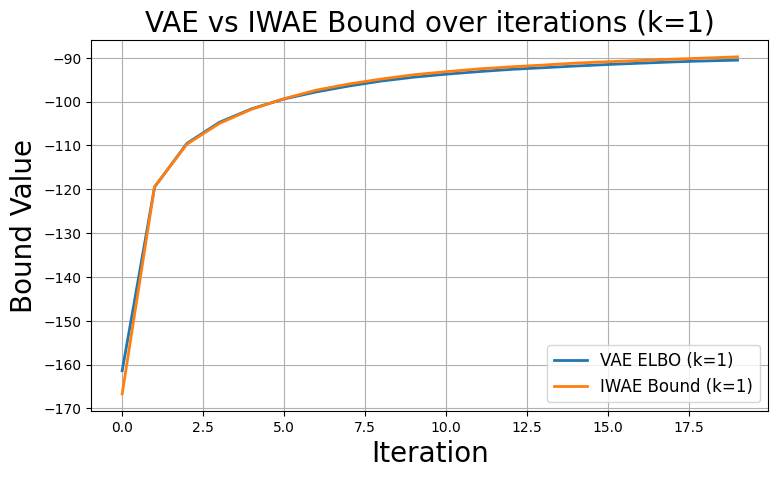

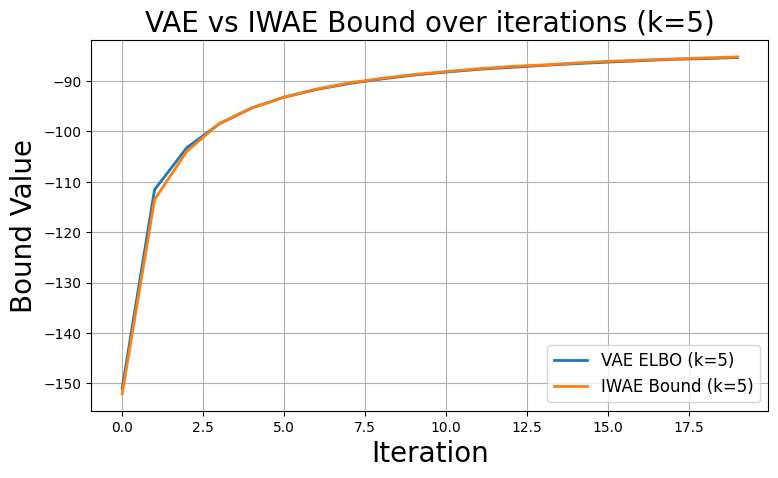

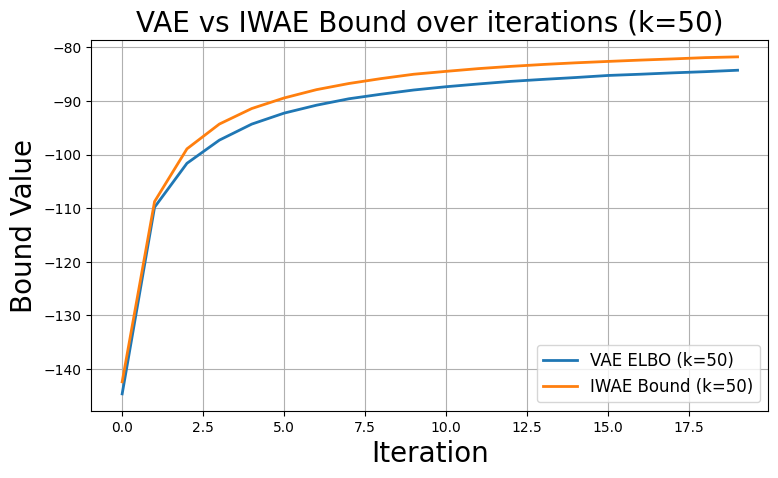

In [35]:
plot_vae_vs_iwae(results_vae, results_iwae, ks, save=True)

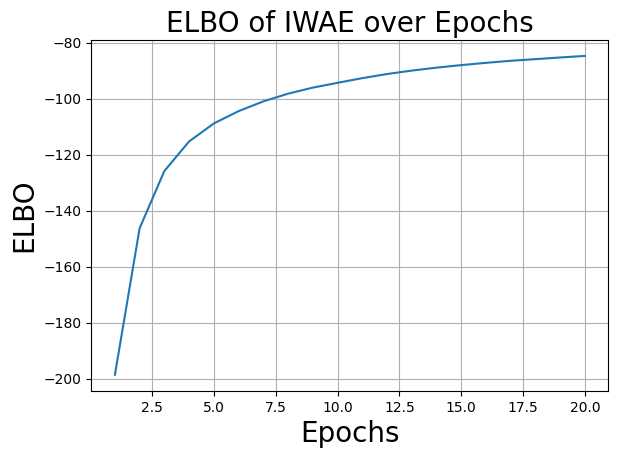

In [31]:
# Plot ELBO curve
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), iwae_bound)
plt.xlabel('Epochs', size=20)
plt.ylabel('ELBO', size=20)
plt.title('ELBO of IWAE over Epochs', size=20)
plt.grid()
plt.tight_layout(pad=1.5)
#plt.savefig("IWAE_ELBO")
plt.show()

### ***Step7: Generate images from test dataset***
With our model trained, now we can start generating images.

First, we will generate images from the latent representations of test data.

Basically, we will sample $z$ from $q(z|x)$ and give it to the generative model (i.e., decoder) $p(x|z)$. The output of the decoder will be displayed as the generated image.

**Q7.1 (1 points)** Fill in the script below to get the latent representations of each batch in the test dataset and reconstruction of the final batch for display in the next cell.

In [ ]:
def evaluate_model(model):
    model.eval()
    # below we get decoder outputs for test data
    with torch.no_grad():
        z_test = []
        x_test = []
        for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
            x_test.append(x)
            x = x.to(device)
            x = x.view(-1, x_dim)
            x = torch.round(x)
            
            theta, mean, log_var, z = model(x)
            z_test.append(z.cpu().detach().numpy())

        # Save the last batch theta for visualization
        theta_batch = model.Decoder(z)

100%|██████████| 79/79 [00:01<00:00, 77.08it/s]


In [ ]:
def plot_both_elbos(elbo, elbo_reg):
    # Plot ELBO curve
    import matplotlib.pyplot as plt
    plt.plot(range(1, epochs + 1), elbo_reg, label="Regular ELBO")
    plt.plot(range(1, epochs + 1), iwae_bound, label="ELBO using IWAE")
    plt.xlabel('Epochs', size=20)
    plt.ylabel('ELBO', size=20)
    plt.title('ELBO over Epochs using VAE and IWAE', size=20)
    plt.grid()
    plt.tight_layout(pad=1.5)
    plt.legend()
    #plt.savefig("Elbo_comp_B.png")
    plt.show()

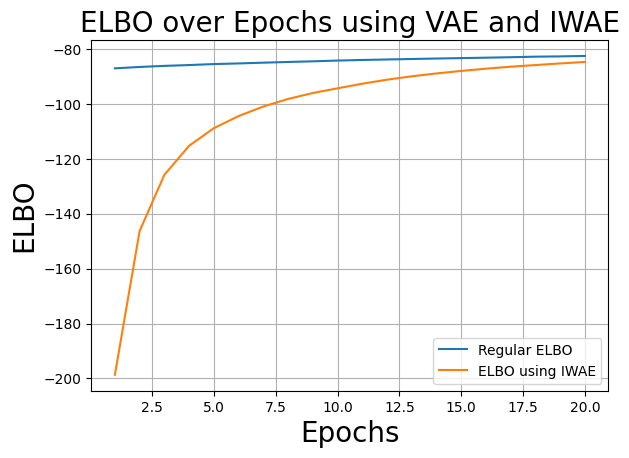

A helper function to display images:

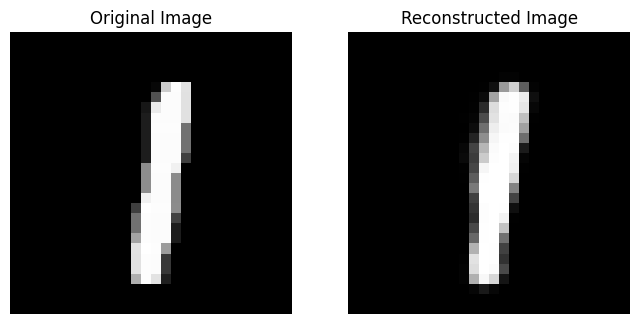

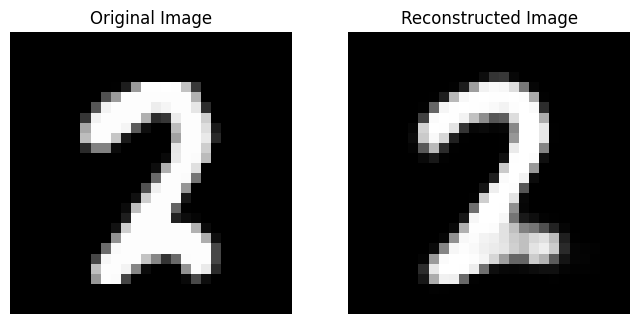

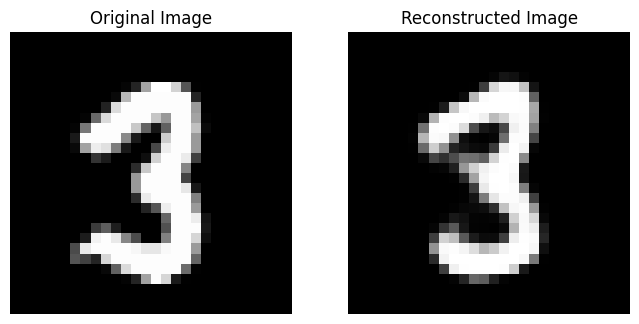

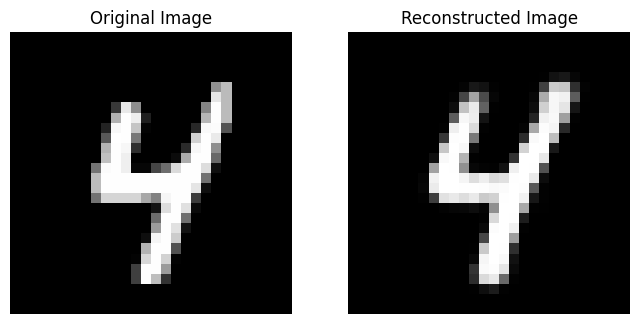

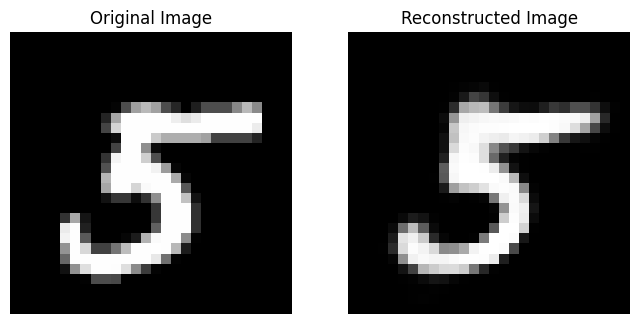

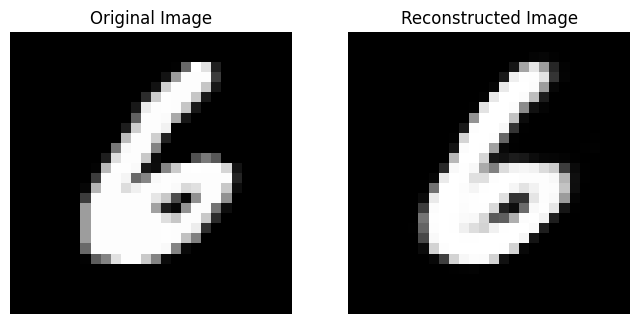

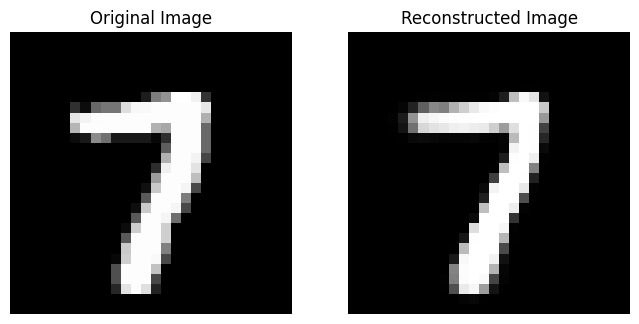

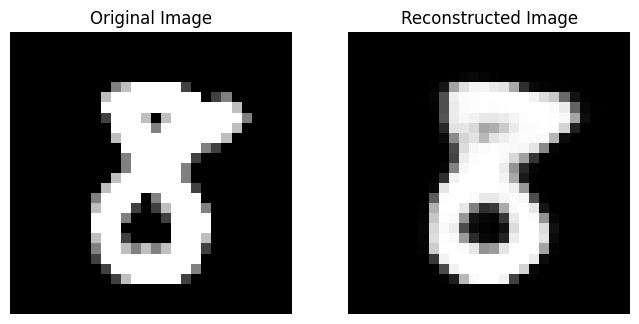

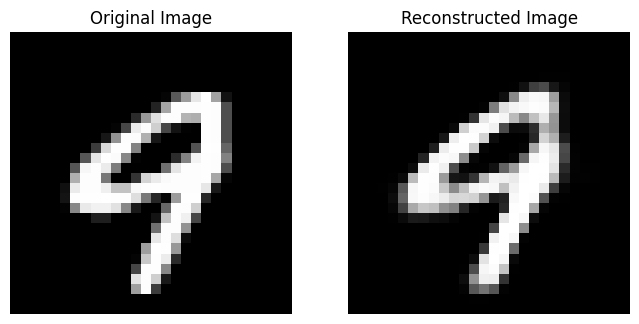

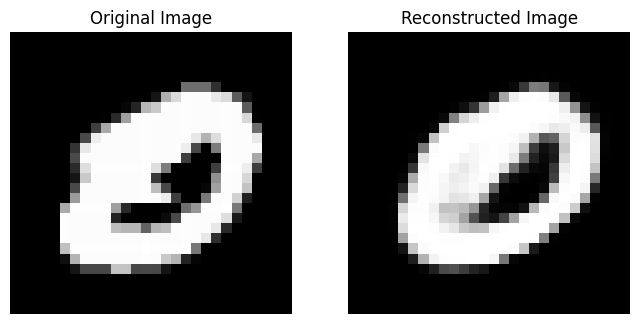

In [ ]:
import matplotlib.pyplot as plt

def compare_images(x, theta, idx):
    # Reshape inputs to (Batch, 28, 28)
    # .cpu().detach().numpy() ensures we can handle tensors on GPU/with gradients
    x_img = x.view(-1, 28, 28)
    theta_img = theta.view(-1, 28, 28)

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot Original
    axes[0].imshow(x_img[idx].cpu().detach().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot Reconstruction
    axes[1].imshow(theta_img[idx].cpu().detach().numpy(), cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis('off')

    plt.show()

# Call the function
theta_batch = theta_batch.cpu()
# theta_batch is the output of the decoder for the last batch in the test set
compare_images(x_test[-1], theta_batch, idx=0)
compare_images(x_test[-1], theta_batch, idx=1)
compare_images(x_test[-1], theta_batch, idx=2)
compare_images(x_test[-1], theta_batch, idx=3)
compare_images(x_test[-1], theta_batch, idx=4)
compare_images(x_test[-1], theta_batch, idx=5)
compare_images(x_test[-1], theta_batch, idx=6)
compare_images(x_test[-1], theta_batch, idx=7)
compare_images(x_test[-1], theta_batch, idx=8)
compare_images(x_test[-1], theta_batch, idx=9)